# INFO 2950 Phase 2
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

### Research Question
Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Can we predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

dan and valence 

### Citation 
Resources use:
1: two y variable on one lineplot: https://stackoverflow.com/questions/55654500/seaborn-plot-with-second-y-axis

In [1]:
# import all the packages needed
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

### Data Descriptions
We collected 4 sets of data to analyze. 

1. data.csv : We downloaded scraped spotify data from calebelgut’s github. The data contains an abundant of information about all the songs released from the years 1921-2020, including danceability, valence, popularity, and energy, for which we attempted to use as a measure of the general population’s music sentiment over the years.
2. top10000song.csv: We had another music dataset of the 10,000 most popular Spotify songs from the years 1050-now.
3. We then downloaded a dataset that corresponds with the monthly unemployment rate from the years 1948-2024, which we used to get the average interest rate over a certain year period.
4. We then downloaded another set of data that included information about the other economic variables, such as the unemployment rate, inflation rate, and real GDP change.

In [2]:
#load all datasets
musicdata = pd.read_csv("data.csv")
econdata = pd.read_csv("index.csv")
undata= pd.read_csv("un.csv")
songdata=pd.read_csv("top10000song.csv")

### Data Collection and Cleaning
Summary:
We begin to inspect first 3 datasets by using .head() and .shape to ensure we have enough data. Then we check if there is any NaN value. If there is, we drop. For interestdata, since each month's interest rate is reported and we are only interested in knowing the year, we create a new dataset that contain the average interest rate of the year.

After cleaning, we create a new dataframe that contain only data that we are interested in exploring the relationship such as dancebility, valence, year, interest rate and unemployment rate by using Inner Join on year (SQL). 

We only use last dataset songdata later after inspecting and analyzing the first 3 data sets. 

In [3]:
#understand the all musicdata we have in the dataset and check the shape to see if we have enough data
print(musicdata.head())
print(musicdata.shape)


   acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8  

In [4]:
# checking to see if we have NaN values
print("Number of music danceability: ", len(musicdata['danceability']))
print("Nan is present: ",\
      np.isnan(musicdata['danceability']).any())

Number of music danceability:  169909
Nan is present:  False


In [5]:
#understand the all econdata we have in the dataset and check the shape to see if we have enough data
print(econdata.head())
print(econdata.shape)

   Year  Month  Day  Federal Funds Target Rate  Federal Funds Upper Target  \
0  1954      7    1                        NaN                         NaN   
1  1954      8    1                        NaN                         NaN   
2  1954      9    1                        NaN                         NaN   
3  1954     10    1                        NaN                         NaN   
4  1954     11    1                        NaN                         NaN   

   Federal Funds Lower Target  Effective Federal Funds Rate  \
0                         NaN                          0.80   
1                         NaN                          1.22   
2                         NaN                          1.06   
3                         NaN                          0.85   
4                         NaN                          0.83   

   Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  
0                        4.6                5.8             NaN  
1                   

In [6]:
# checking to see if we have NaN values
print("Number of rows in fed fund rate: ", len(econdata['Effective Federal Funds Rate']))
print("Nan is present: ",\
      np.isnan(econdata['Effective Federal Funds Rate']).any())

Number of rows in fed fund rate:  904
Nan is present:  True


In [7]:
#Nan vaue is found, drop it 
econdata.dropna(subset=['Effective Federal Funds Rate'], inplace=True)
print(np.isnan(econdata['Effective Federal Funds Rate']).any())
#check the shape to see if we have enough data
print(econdata.shape)

False
(752, 10)


In [8]:
#rename the Effective Federal Funds Rate col, easier without space for writing SQL later
print(econdata.columns)
econdata.rename(columns={"Effective Federal Funds Rate": "fedfundrate"}, inplace=True)
print(econdata.columns)

Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'Effective Federal Funds Rate', 'Real GDP (Percent Change)',
       'Unemployment Rate', 'Inflation Rate'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'fedfundrate', 'Real GDP (Percent Change)', 'Unemployment Rate',
       'Inflation Rate'],
      dtype='object')


In [9]:
#understand the all interestdata we have in the dataset and check the shape to see if we have enough data
print(undata.head())
print(undata.shape)

         DATE  UNRATE
0  1948-01-01     3.4
1  1948-02-01     3.8
2  1948-03-01     4.0
3  1948-04-01     3.9
4  1948-05-01     3.5
(921, 2)


In [10]:
# checking to see if we have NaN values
print("Number of rows in UNRate: ", len(undata['UNRATE']))
print("Nan is present: ",\
      np.isnan(undata['UNRATE']).any())

Number of rows in UNRate:  921
Nan is present:  False


In [11]:
# in order to merge the data, we need to convert the date format into datetime

#check date type
print(undata["DATE"].dtype)
# convert to datetime format
undata['DATE']= pd.to_datetime(undata['DATE'], format='%Y-%m-%d', errors='coerce')
undata

object


,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2


Data manipulation: we average the interest rate and grouped by year to be the same scale as the spotify dataset. 

In [13]:
# modify econdata to find avg interestrate for each year
newundata = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS UnemploymentRate FROM undata GROUP BY year(DATE)").df()
newundata

,Year,UnemploymentRate
0,1948,3.750000
1,1949,6.050000
2,1950,5.208333
3,1951,3.283333
4,1952,3.025000
...,...,...
72,2021,5.350000
73,2022,3.633333
74,2023,3.625000
75,2024,4.000000


In [14]:
# use sql to get a data frame with danceabilty, valence, interest rate and unemployment
cleandata= duckdb.sql("SELECT danceability, valence, musicdata.year, fedfundrate FROM\
            musicdata INNER JOIN econdata ON musicdata.year = econdata.year").df()
cleandata= duckdb.sql("SELECT danceability, valence, cleandata.year, \
        fedfundrate, UnemploymentRate FROM cleandata INNER JOIN newundata\
            ON cleandata.year = newundata.Year").df()
cleandata

,danceability,valence,year,fedfundrate,UnemploymentRate
0,0.469,0.5180,1994,5.29,6.10
1,0.822,0.5930,1994,5.29,6.10
2,0.420,0.0737,1994,5.29,6.10
3,0.593,0.8550,1994,5.29,6.10
4,0.569,0.8150,1994,5.29,6.10
...,...,...,...,...,...
1502795,0.244,0.4950,1991,5.21,6.85
1502796,0.727,0.7360,1991,5.21,6.85
1502797,0.518,0.7250,1991,5.21,6.85
1502798,0.919,0.9250,1991,5.21,6.85


### Data visualization and analysis
Summary:


In [15]:
# inspect the correlation
cleandata.corr()

,danceability,valence,year,fedfundrate,UnemploymentRate
danceability,1.000000,0.551024,0.193483,-0.015057,0.045752
valence,0.551024,1.000000,-0.055054,0.109555,0.007659
year,0.193483,-0.055054,1.000000,-0.253908,0.239239
fedfundrate,-0.015057,0.109555,-0.253908,1.000000,0.060750
UnemploymentRate,0.045752,0.007659,0.239239,0.060750,1.000000


Danceability and valence has a highest correlation as what we expected. However, danceability has a weak +ve correlation with Unemployment rate (0.04) and a weak -ve correlation (-0.02) with fedfundrate. In addition, valence has an even lower +ve correlation with Unemployment rate (0.007)and Interest Rate (0.1). 


<Axes: xlabel='year', ylabel='valence'>

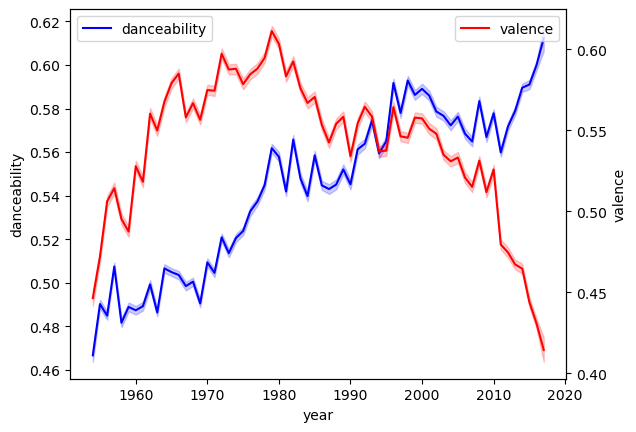

In [16]:
# visualize time series of valence and danceability across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax1, color='blue', label='danceability')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

From the graph, we can see that the overall trend between danceability and valence is mostly similar, except for the period from 2010 onwards, where danceability increases while valence decreases. Note that both danceability and valence are the average of that year as we have multiple songs in a year from the dataset. 

<Axes: xlabel='year', ylabel='valence'>

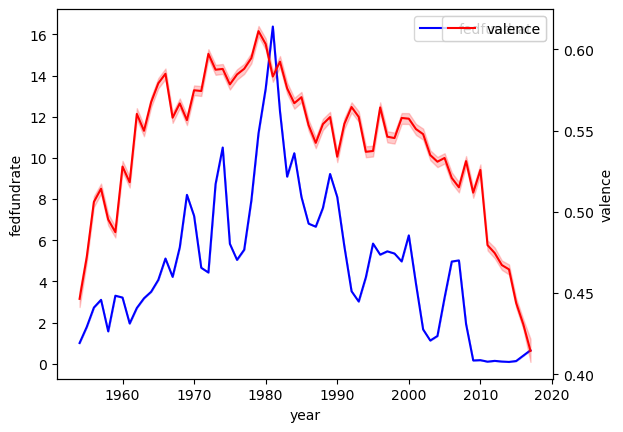

In [17]:
# visualize time series of valence and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

<Axes: xlabel='year', ylabel='danceability'>

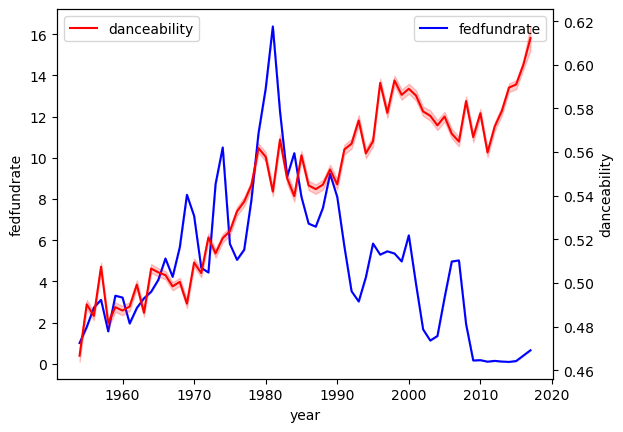

In [18]:
# visualize time series of danceability and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

<Axes: xlabel='year', ylabel='valence'>

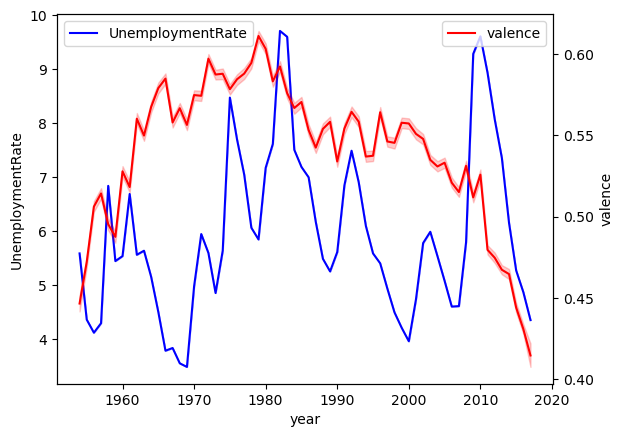

In [19]:
# visualize time series of valence and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

<Axes: xlabel='year', ylabel='danceability'>

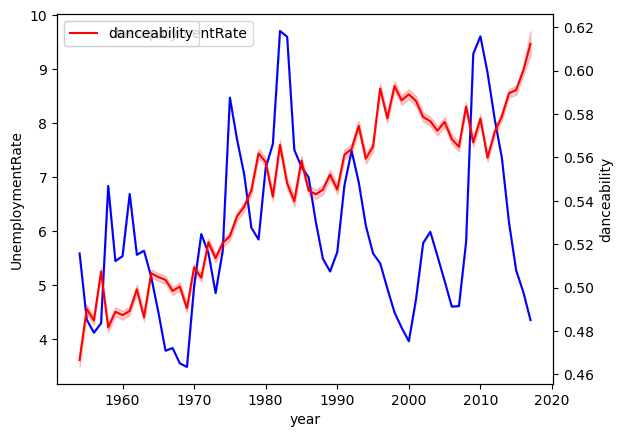

In [20]:
# visualize time series of danceability and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

Inspect why dancebility and valence has such weak correlation with fedfundrate and unemploymentrate by plotting scatter plots. 
We found out that regardless of the fed fund rate and unemployment rate, we have songs with a full spectrum of danceability and valence. This might justify why there is a week correlation. 

NOTE: we reduce the transparency of the dot to make sure we can determine overlapping to get more accurate perceptions of the fange of songs' danceability and valence. 

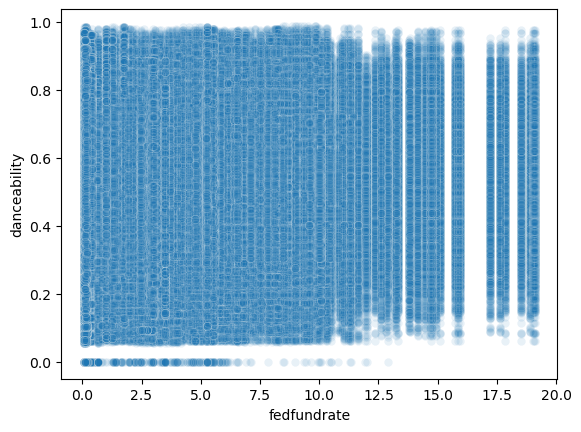

In [21]:
dance_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="danceability", alpha=0.1)


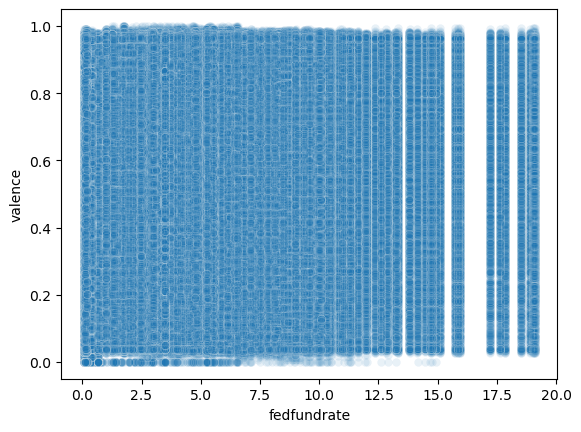

In [22]:
valence_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="valence", alpha=0.1)

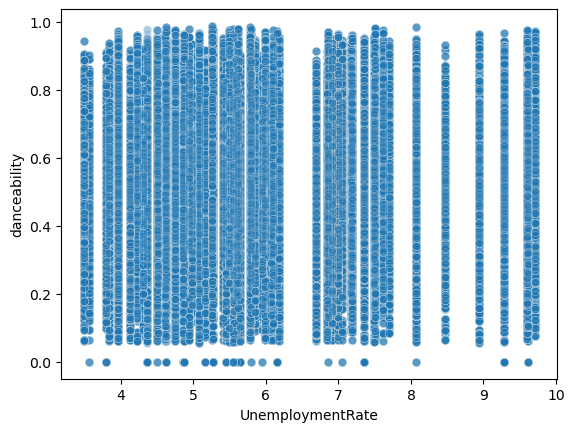

In [23]:
dance_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="danceability", alpha=0.1)

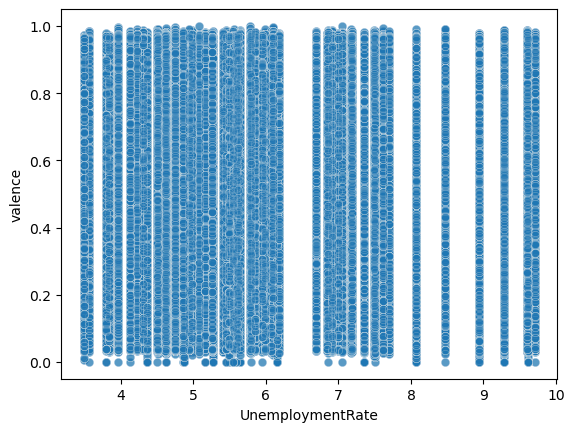

In [24]:
valence_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="valence", alpha=0.1)

** Data Cleaning: While looking through the different factors of calebelgut's dataset, we realized that a potential problem that caused the low correlation may be due to the fact that we did not account for each song's popularity, thus not accurately representing the music sentiment of the general population. Therefore we did further data cleaning and only considered songs above a certain popularity.**

The Popularity scale was from 0 to 100 and after looking at summary stats, we decided to filter to only songs with a rating greater or equal to 70.

In [25]:
# confirm the scale of popularity
musicdata['popularity'].unique()

array([  0,   1,   2,   3,   7,   6,   5,   4,   8,  14,  13,  11,  10,
        12,   9,  15,  19,  17,  18,  16,  20,  24,  21,  23,  22,  25,
        42,  28,  27,  37,  36,  35,  30,  26,  29,  44,  32,  33,  31,
        41,  46,  34,  45,  40,  38,  39,  54,  48,  58,  52,  47,  43,
        49,  51,  56,  55,  50,  57,  59,  66,  53,  61,  60,  62,  64,
        65,  69,  72,  63,  70,  68,  67,  71,  74,  75,  78,  81,  77,
        73,  80,  76,  79,  82,  83,  85,  84,  91,  92,  87,  86,  89,
        95,  93,  88,  90,  94,  99,  96, 100,  97])

In [26]:
#check the mean, mode and median of songs' popularity
print(musicdata['popularity'].mean())
print(musicdata['popularity'].mode())
print(musicdata['popularity'].median())

31.55660971461194
0    0
Name: popularity, dtype: int64
33.0


In [27]:
#create a dataframe just as before but with popularity>=70

# checking to see if we have NaN values
print("Number of music popularity: ", len(musicdata['popularity']))
print("Nan is present: ",\
      np.isnan(musicdata['popularity']).any())

Number of music popularity:  169909
Nan is present:  False


In [28]:
# use sql to get a data frame with danceabilty, valence, popularity, interest rate and unemployment rate
popdata= duckdb.sql("SELECT danceability, valence, popularity, musicdata.year, fedfundrate FROM\
            musicdata INNER JOIN econdata ON musicdata.year = econdata.year WHERE popularity >=70").df()
popdata= duckdb.sql("SELECT danceability, valence, popularity, popdata.year, \
        fedfundrate, UnemploymentRate FROM popdata INNER JOIN newundata\
            ON popdata.year = newundata.Year").df()
popdata

,danceability,valence,popularity,year,fedfundrate,UnemploymentRate
0,0.464,0.479,72,2013,0.09,7.358333
1,0.832,0.674,70,2013,0.09,7.358333
2,0.728,0.872,71,2013,0.09,7.358333
3,0.724,0.324,71,2014,0.12,6.158333
4,0.738,0.355,71,2014,0.12,6.158333
...,...,...,...,...,...,...
23411,0.456,0.243,74,1991,4.81,6.850000
23412,0.572,0.844,71,1991,4.81,6.850000
23413,0.452,0.805,71,1991,4.81,6.850000
23414,0.534,0.102,70,1991,4.81,6.850000


In [29]:
popdata.corr()

,danceability,valence,popularity,year,fedfundrate,UnemploymentRate
danceability,1.000000,0.412687,0.007049,0.159455,-0.081326,0.029703
valence,0.412687,1.000000,-0.051501,-0.256091,0.250243,0.062660
popularity,0.007049,-0.051501,1.000000,0.034470,-0.025550,-0.018332
year,0.159455,-0.256091,0.034470,1.000000,-0.769219,0.007697
fedfundrate,-0.081326,0.250243,-0.025550,-0.769219,1.000000,-0.056686
UnemploymentRate,0.029703,0.062660,-0.018332,0.007697,-0.056686,1.000000


Danceability and valence has a highest correlation (from 0.55 to 0.41) as what we expected but lower than what we had before filtering out songs with popularity less than 70. However, danceability has a weaker +ve correlation with Unemployment rate (from 0.04 to 0.03) and a greater -ve correlation (-0.02 to -0.08) with fedfundrate. In addition, valence has a significant higher +ve correlation with Unemployment rate (from 0.007 to 0.06)and Interest Rate (0.1 to 0.25). 

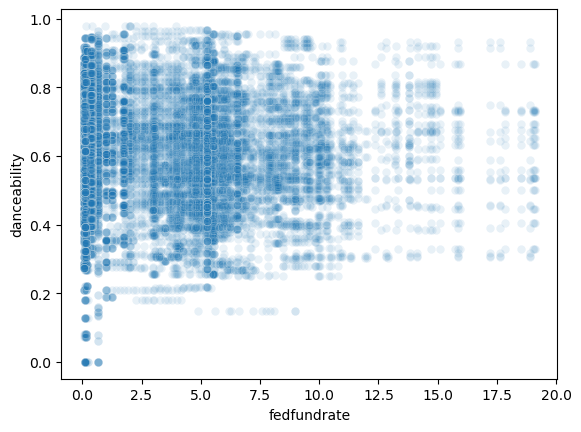

In [30]:
dance_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="danceability", alpha=0.1)

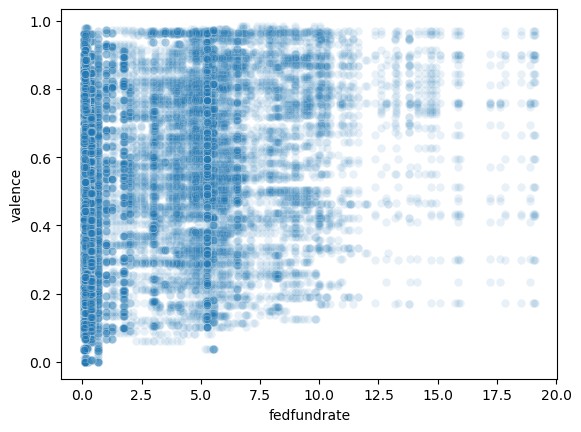

In [31]:
valence_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="valence", alpha=0.1)

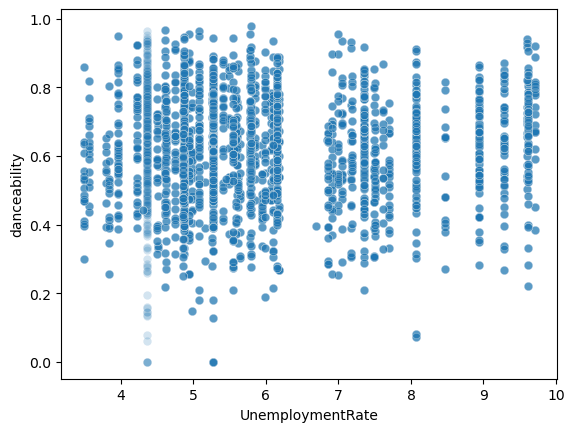

In [32]:
dance_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="danceability", alpha=0.1)

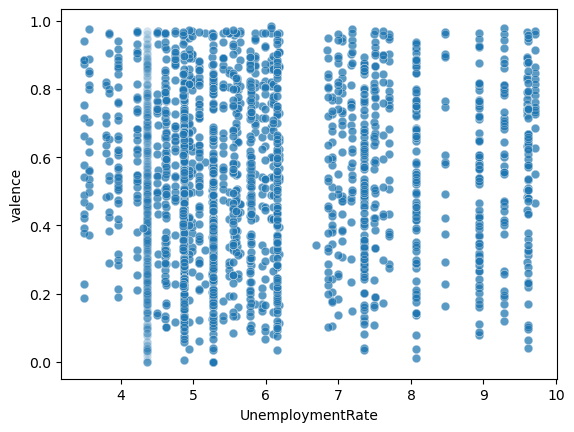

In [33]:
valence_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="valence", alpha=0.1)

### Sanity check

We decide to use another dataset to check if we can yield better corr. This dataset contains top 10000 songs from 1960 to 2023 and has valence a column.

### Data Cleaning

In [34]:
#rename the Album Release Date col, easier without space for writing SQL later
# print(songdata.head())
songdata.rename(columns={"Album Release Date": "Album_Release_Date"}, inplace=True)
songdata

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album_Release_Date,Album Image URL,...,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,spotify:album:4MC0ZjNtVP1nDD5lsLxFjc,Songs Collection,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,1992-08-03,https://i.scdn.co/image/ab67616d0000b27355346b...,...,0.0480,0.015800,0.112000,0.4080,0.504,111.458,4.0,NaN,Jams Communications,"C 1992 Copyright Control, P 1992 Jams Communic..."
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,spotify:album:5xLAcbvbSAlRtPXnKkggXA,Pitbull Starring In Rebelution,spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,2009-10-23,https://i.scdn.co/image/ab67616d0000b27326d73a...,...,0.1490,0.014200,0.000021,0.2370,0.800,127.045,4.0,NaN,Mr.305/Polo Grounds Music/J Records,"P (P) 2009 RCA/JIVE Label Group, a unit of Son..."
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:3WNxdumkSMGMJRhEgK80qx,...Baby One More Time (Digital Deluxe Version),spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,1999-01-12,https://i.scdn.co/image/ab67616d0000b2738e4986...,...,0.0305,0.560000,0.000001,0.3380,0.706,74.981,4.0,NaN,Jive,P (P) 1999 Zomba Recording LLC
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,spotify:album:6lL6HugNEN4Vlc8sj0Zcse,"Lola vs. Powerman and the Moneygoround, Pt. On...",spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,2014-10-20,https://i.scdn.co/image/ab67616d0000b2731e7c53...,...,0.2590,0.568000,0.000051,0.0384,0.833,75.311,4.0,NaN,Sanctuary Records,"C © 2014 Sanctuary Records Group Ltd., a BMG C..."
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,spotify:album:0c78nsgqX6VfniSNWIxwoD,Let It Bleed,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,1969-12-05,https://i.scdn.co/image/ab67616d0000b27373d927...,...,0.0687,0.675000,0.000073,0.2890,0.497,85.818,4.0,NaN,Universal Music Group,"C © 2002 ABKCO Music & Records Inc., P ℗ 2002 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,spotify:track:3kcKlOkQQEPVwxwljbGJ5p,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",spotify:album:2NIChqkijGw4r4Dqfmg0A3,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",2022-06-17,https://i.scdn.co/image/ab67616d0000b273e1cafe...,...,0.0562,0.184000,0.000020,0.3090,0.400,125.975,4.0,NaN,Virgin,"C © 2022 Topic, under exclusive license to Uni..."
9995,spotify:track:5k9QrzJFDAp5cXVdzAi02f,Never Say Never - Radio Edit,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,spotify:album:2n506u3HKN3CaEDvAjv5Ct,Never Say Never,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,2005-10-24,https://i.scdn.co/image/ab67616d0000b273b65ad4...,...,0.0340,0.000354,0.011200,0.3380,0.767,130.978,4.0,NaN,Vicious,"C 2005 Vicious, a division of Vicious Recordin..."
9996,spotify:track:5ydeCNaWDmFbu4zl0roPAH,Groovejet (If This Ain't Love) [feat. Sophie E...,"spotify:artist:4bmymFwDu9zLCiTRUmrewb, spotify...","Spiller, Sophie Ellis-Bextor",spotify:album:20Q3pGpYiyicF32x5L8ppH,Groovejet (If This Ain't Love) [feat. Sophie E...,spotify:artist:4bmymFwDu9zLCiTRUmrewb,Spiller,2000-08-14,https://i.scdn.co/image/ab67616d0000b27342781a...,...,0.0389,0.000132,0.088900,0.3610,0.626,123.037,4.0,NaN,Defected Records,"C © 2021 Defected Records Limited, P ℗ 2021 De..."
9997,spotify:track:0zKbDrEXKpnExhGQRe9dxt,Lay Low,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,spotify:album:0EYKSXXTsON8ZA95BuCoXn,Lay Low,spotify:artist:2o5jDhtH

In [35]:
songdata['Album_Release_Date'] = pd.to_datetime(songdata['Album_Release_Date'], format='%Y-%m-%d', errors='coerce')

In [36]:
songdata = duckdb.sql("SELECT *, year(Album_Release_Date) AS year FROM songdata").df()
songdata

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album_Release_Date,Album Image URL,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,spotify:album:4MC0ZjNtVP1nDD5lsLxFjc,Songs Collection,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,1992-08-03,https://i.scdn.co/image/ab67616d0000b27355346b...,...,0.015800,0.112000,0.4080,0.504,111.458,4.0,NaN,Jams Communications,"C 1992 Copyright Control, P 1992 Jams Communic...",1992.0
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,spotify:album:5xLAcbvbSAlRtPXnKkggXA,Pitbull Starring In Rebelution,spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,2009-10-23,https://i.scdn.co/image/ab67616d0000b27326d73a...,...,0.014200,0.000021,0.2370,0.800,127.045,4.0,NaN,Mr.305/Polo Grounds Music/J Records,"P (P) 2009 RCA/JIVE Label Group, a unit of Son...",2009.0
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:3WNxdumkSMGMJRhEgK80qx,...Baby One More Time (Digital Deluxe Version),spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,1999-01-12,https://i.scdn.co/image/ab67616d0000b2738e4986...,...,0.560000,0.000001,0.3380,0.706,74.981,4.0,NaN,Jive,P (P) 1999 Zomba Recording LLC,1999.0
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,spotify:album:6lL6HugNEN4Vlc8sj0Zcse,"Lola vs. Powerman and the Moneygoround, Pt. On...",spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,2014-10-20,https://i.scdn.co/image/ab67616d0000b2731e7c53...,...,0.568000,0.000051,0.0384,0.833,75.311,4.0,NaN,Sanctuary Records,"C © 2014 Sanctuary Records Group Ltd., a BMG C...",2014.0
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,spotify:album:0c78nsgqX6VfniSNWIxwoD,Let It Bleed,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,1969-12-05,https://i.scdn.co/image/ab67616d0000b27373d927...,...,0.675000,0.000073,0.2890,0.497,85.818,4.0,NaN,Universal Music Group,"C © 2002 ABKCO Music & Records Inc., P ℗ 2002 ...",1969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,spotify:track:3kcKlOkQQEPVwxwljbGJ5p,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",spotify:album:2NIChqkijGw4r4Dqfmg0A3,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",2022-06-17,https://i.scdn.co/image/ab67616d0000b273e1cafe...,...,0.184000,0.000020,0.3090,0.400,125.975,4.0,NaN,Virgin,"C © 2022 Topic, under exclusive license to Uni...",2022.0
9995,spotify:track:5k9QrzJFDAp5cXVdzAi02f,Never Say Never - Radio Edit,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,spotify:album:2n506u3HKN3CaEDvAjv5Ct,Never Say Never,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,2005-10-24,https://i.scdn.co/image/ab67616d0000b273b65ad4...,...,0.000354,0.011200,0.3380,0.767,130.978,4.0,NaN,Vicious,"C 2005 Vicious, a division of Vicious Recordin...",2005.0
9996,spotify:track:5ydeCNaWDmFbu4zl0roPAH,Groovejet (If This Ain't Love) [feat. Sophie E...,"spotify:artist:4bmymFwDu9zLCiTRUmrewb, spotify...","Spiller, Sophie Ellis-Bextor",spotify:album:20Q3pGpYiyicF32x5L8ppH,Groovejet (If This Ain't Love) [feat. Sophie E...,spotify:artist:4bmymFwDu9zLCiTRUmrewb,Spiller,2000-08-14,https://i.scdn.co/image/ab67616d0000b27342781a...,...,0.000132,0.088900,0.3610,0.626,123.037,4.0,NaN,Defected Records,"C © 2021 Defected Records Limited, P ℗ 2021 De...",2000.0
9997,spotify:track:0zKbDrEXKpnExhGQRe9dxt,Lay Low,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,spotify:album:0EYKSXXTsON8ZA95BuCoXn,Lay Low,spotify:artist:2o5jDhtHVPhrJdv

In [37]:
# no need to get popularity here in this dataset, b/c 
# this new data includes top 10000 songs
newcleandata= duckdb.sql("SELECT songdata.Year,\
        valence, UnemploymentRate FROM songdata INNER JOIN \
        newundata ON songdata.year = newundata.year").df()
newcleandata

,year,Valence,UnemploymentRate
0,1992.0,0.504,7.491667
1,2009.0,0.800,9.283333
2,1999.0,0.706,4.216667
3,2014.0,0.833,6.158333
4,1969.0,0.497,3.491667
...,...,...,...
8617,2022.0,0.400,3.633333
8618,2005.0,0.767,5.083333
8619,2000.0,0.626,3.966667
8620,2023.0,0.420,3.625000


In [40]:
# checking to see if we have NaN values
print("Number of rows in valence: ", len(newcleandata['Valence']))
print("Nan is present: ",\
      np.isnan(newcleandata['Valence']).any())

Number of rows in valence:  8622
Nan is present:  False


In [41]:
newcleandata.corr()

,year,Valence,UnemploymentRate
year,1.000000,-0.191757,0.035542
Valence,-0.191757,1.000000,0.022680
UnemploymentRate,0.035542,0.022680,1.000000


Indeed the corr of valence and unemploymentrate is almost similar to the first data set, we have 0.02 here and 0.06 in the previous dataset.

### Data Limitations¶
The spotify data set and 2nd song data set that we have represent the popularity globally. Couldn't find a dataset based on only the US population.

#### Questions
- Given the low correlation and linear regression coefficient, is there a better model for us to train the data?
- How can we transform our model to better fit the data?
- How and do we have to cite resources?